# Aygaz Görüntü İşleme Bootcampi

## Proje Hakkında
Bu projedeki amaç çeşitli hayvanları sınıflandıran bir CNN modeli kurmak. 

Bu proje kapsamında https://www.kaggle.com/datasets/rrebirrth/animals-with-attributes-2 veriseti kullanılmıştır.

Bu veri setinden 10 farklı hayvan sınıfı (collie, dolphin, elephant, fox, moose, rabbit, sheep, squirrel, giant panda ve polar bear) seçilmiş, görüntüler üzerinde veri ön işleme adımları gerçekleştirilmiştir. Model eğitildikten sonra, test seti ışık değişimleri ve bulanıklaştırma gibi manipülasyonlara tabi tutulmuş, ardından renk sabitliği algoritması uygulanarak performans değerlendirmesi yapılmıştır.

## Veri Setini Hazırlama
Burada projede kullanılacak olan 10 hayvan sınıfı belirlenmiş her sınıf için 650 adet fotoğraf seçilmiş, fotoğraflar 128x128 boyutuna ölçeklendirilmiş ve 0 ile 1 arasına normalize edilmiştir.

In [1]:
#gerekli kütüphaneler
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [2]:
#belirlenen hayvan sınıfları ve resim boyutu
selected_classes = ["collie", "dolphin", "elephant", "fox", "moose", "rabbit", "sheep", "squirrel", "giant+panda", "polar+bear"]
image_size = (128, 128)
image_count = 650

data_dir = "/kaggle/input/animals-with-attributes-2/Animals_with_Attributes2/JPEGImages"

#veri setinin yüklenmesi
def load_data(data_dir, selected_classes, image_size, image_count):
    X, y = [], [] #X normalize edilmiş görüntüler, y ise etiketlerini tutar
    for class_index, class_name in enumerate(selected_classes):
        class_path = os.path.join(data_dir, class_name)
        
        if os.path.exists(class_path):
            images = os.listdir(class_path)[:image_count]
            for img_name in images:
                img_path = os.path.join(class_path, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, image_size)
                    img = img / 255.0  # Normalizasyon edilir
                    X.append(img)
                    y.append(class_index)
        else:
            print("path not found")
    
    return np.array(X), np.array(y)

### eğitim ve test verilerine %70'e %30 olacak şekilde ayırma

In [3]:
X, y = load_data(data_dir, selected_classes, image_size, image_count)

# Veriyi eğitim %70 ve test %30 seti olarak ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=9)

# Etiketleri kategorik hale getirme
y_train = to_categorical(y_train, num_classes=len(selected_classes))
y_test = to_categorical(y_test, num_classes=len(selected_classes))

print(f"Eğitim seti boyutu: Görüntüler => {X_train.shape}, Etiketler => {y_train.shape}")
print(f"Test seti boyutu: Görüntüler => {X_test.shape}, Etiketler => {y_test.shape}")

Eğitim seti boyutu: Görüntüler => (4550, 128, 128, 3), Etiketler => (4550, 10)
Test seti boyutu: Görüntüler => (1950, 128, 128, 3), Etiketler => (1950, 10)


## Modelin Eğitilmesi

Bu bölümde, model seçilen eğitim verisi üzerinde eğitilmiştir. Eğitim verilerinin çeşitliliğini artırmak için veri artırma teknikleri uygulanmıştır.

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Veri artırma işlevi
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)
datagen.fit(X_train)

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

def create_model():
    model = Sequential([
        Input(shape=(128, 128, 3)),  
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.4),
        Dense(len(selected_classes), activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_model()

In [6]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       7,372,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,393,610 (28.20 MB)

 Trainable params: 7,393,610 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 75s 512ms/step - accuracy: 0.1901 - loss: 2.6832 - val_accuracy: 0.3877 - val_loss: 1.8037
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 83s 522ms/step - accuracy: 0.3906 - loss: 1.7470 - val_accuracy: 0.4508 - val_loss: 1.6280
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 74s 515ms/step - accuracy: 0.4700 - loss: 1.5368 - val_accuracy: 0.4774 - val_loss: 1.5194
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 83s 521ms/step - accuracy: 0.5671 - loss: 1.2786 - val_accuracy: 0.5277 - val_loss: 1.3816
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 76s 529ms/step - accuracy: 0.6301 - loss: 1.0565 - val_accuracy: 0.5308 - val_loss: 1.4264
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 81s 524ms/step - accuracy: 0.7181 - loss: 0.8435 - val_accuracy: 0.5451 - val_loss: 1.4271
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 75s 528ms/step - accuracy: 0.7704 - loss: 0.6921 - val_accuracy: 0.5703 - val_loss: 1.4498
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 75s 527ms/step - accuracy: 0.8066 - loss: 0

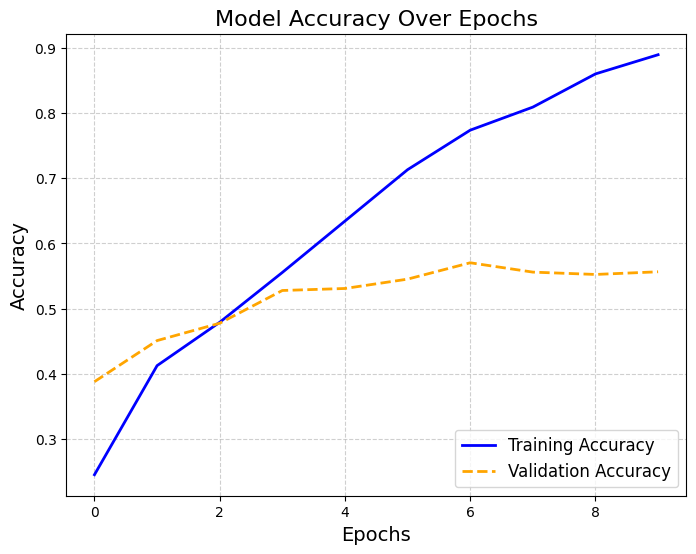

In [7]:
# Modeli eğitme
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

plt.figure(figsize=(8, 6))  
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange', linestyle='--', linewidth=2)
plt.title('Model Accuracy Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)  
plt.show()

## Modelin Test Edilmesi

In [8]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - accuracy: 0.5512 - loss: 1.7278
Test Loss: 1.7233526706695557, Test Accuracy: 0.5564102530479431


## Görüntülerin Manipüle Edilmesi

In [18]:
def get_manipulated_images(images):
    bright_images = []
    blurred_images = []
    for img in images:
        bright_img = cv2.convertScaleAbs(img, alpha=1.2, beta=10)  # Parlaklık ayarı
        blurred_img = cv2.GaussianBlur(img, (5, 5), 10)           # Bulanıklaştırma

        # Normalleştir ve listeye ekle
        bright_images.append(bright_img / 255.0)
        blurred_images.append(blurred_img / 255.0)

    # NumPy dizisine dönüştür
    return np.array(bright_images), np.array(blurred_images)


In [11]:
def gray_world(images):
    corrected_images = []
    for img in images:
        avg_b = np.mean(img[:, :, 0])  # Calculate the mean for the Blue channel
        avg_g = np.mean(img[:, :, 1])  # Calculate the mean for the Green channel
        avg_r = np.mean(img[:, :, 2])  # Calculate the mean for the Red channel

        avg_gray = (avg_b + avg_g + avg_r) / 3  # Calculate the average gray level

        img[:, :, 0] = np.clip(img[:, :, 0] * (avg_gray / avg_b), 0, 255)  # Adjust Blue channel
        img[:, :, 1] = np.clip(img[:, :, 1] * (avg_gray / avg_g), 0, 255)  # Adjust Green channel
        img[:, :, 2] = np.clip(img[:, :, 2] * (avg_gray / avg_r), 0, 255)  # Adjust Red channel

        corrected_images.append(img)
    return np.array(corrected_images)

In [22]:
# Manipüle edilmiş veri setini al
X_test_bright, X_test_blurred = get_manipulated_images(X_test)

# Boyut ve veri tipi kontrolü
print(X_test_bright.shape, X_test_bright.dtype)  # (1950, 128, 128, 3) ve float32 olmalı
print(X_test_blurred.shape, X_test_blurred.dtype)

(1950, 128, 128, 3) float64
(1950, 128, 128, 3) float64


## Modelin Manipüle Edilmiş Test Setleriyle Denenmesi

In [23]:
# modelin gray world algoritması için değerlendirilmesi
X_test_gray = gray_world(X_test)
loss_gray, accuracy_gray = model.evaluate(X_test_gray, y_test)
print(f"Gray World Test Accuracy: {accuracy_gray * 100:.2f}%")

61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 117ms/step - accuracy: 0.4642 - loss: 2.1612
Gray World Test Accuracy: 47.54%


In [24]:
# Model değerlendirmesi
loss_bright, accuracy_bright = model.evaluate(X_test_bright, y_test)
print(f"Parlaklaştırılmış Test Doğruluğu: {accuracy_bright * 100:.2f}%")

loss_blurred, accuracy_blurred = model.evaluate(X_test_blurred, y_test)
print(f"Bulanıklaştırılmış Test Doğruluğu: {accuracy_blurred * 100:.2f}%")

61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 117ms/step - accuracy: 0.0896 - loss: 4.3467
Parlaklaştırılmış Test Doğruluğu: 10.15%
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - accuracy: 0.0896 - loss: 4.3939
Bulanıklaştırılmış Test Doğruluğu: 10.15%


## Test setlerinin karşılaştırılması

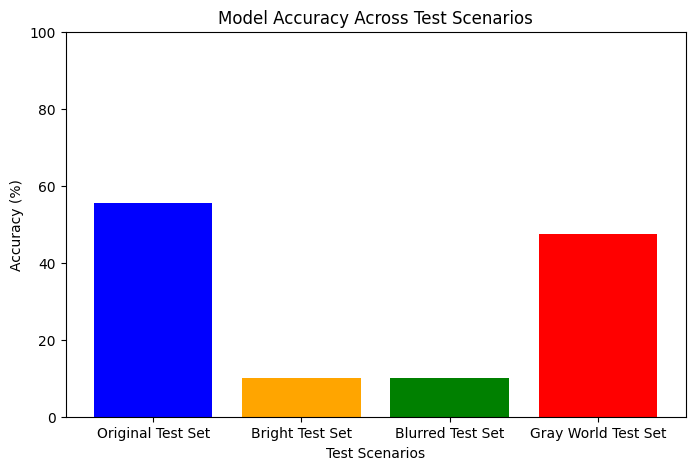

In [27]:
scenarios = ['Original Test Set', 'Bright Test Set', 'Blurred Test Set', 'Gray World Test Set']
accuracies = [test_accuracy * 100, accuracy_bright * 100, accuracy_blurred * 100, accuracy_gray*100]

# Plot the results
plt.figure(figsize=(8, 5))
plt.bar(scenarios, accuracies, color=['blue', 'orange', 'green', 'red'])
plt.title('Model Accuracy Across Test Scenarios')
plt.xlabel('Test Scenarios')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.show()

In [25]:
print(f"Normal test seti için accuracy: {test_accuracy}")
print(f"Parlaklaştırılmış test seti için accuracy: {accuracy_bright}")
print(f"Bulanıklaştırılmış test seti için accuracy: {accuracy_blurred}")
print(f"Gray World test seti için accuracy: {accuracy_gray}")

Normal test seti için accuracy: 0.5564102530479431
Parlaklaştırılmış test seti için accuracy: 0.10153846442699432
Bulanıklaştırılmış test seti için accuracy: 0.10153846442699432
Gray World test seti için accuracy: 0.4753846228122711
